In [24]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb


In [25]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")


In [26]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (1460, 81)
Test shape: (1459, 80)


In [28]:
#EDA - Quick Overview
print(train_df.describe())
print(train_df.info())

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

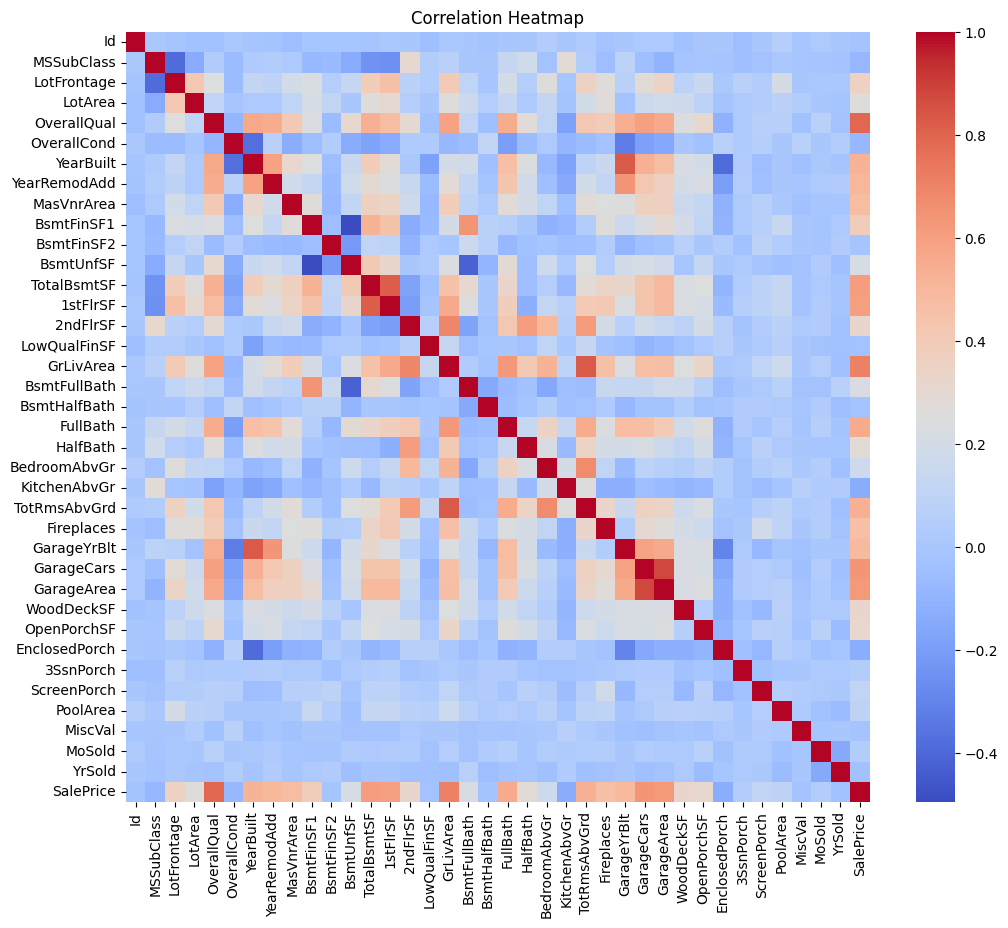

In [32]:
# Correlation heatmap (only numerical features)
plt.figure(figsize=(12, 10))
sns.heatmap(train_df.select_dtypes(include=np.number).corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()


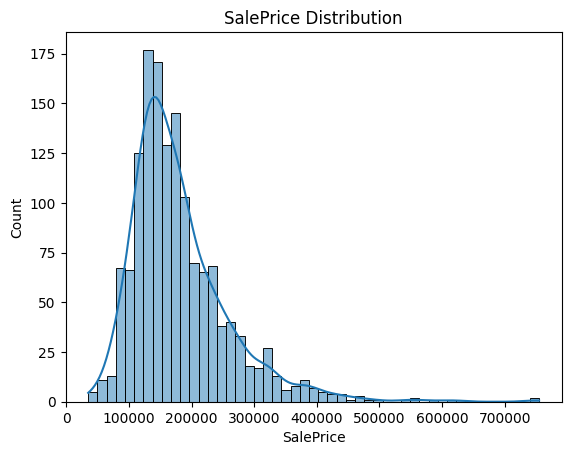

In [33]:
# SalePrice distribution
sns.histplot(train_df['SalePrice'], kde=True)
plt.title("SalePrice Distribution")
plt.show()

In [34]:
# Log-transform target to reduce skewness
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])


In [35]:
train_ID = train_df['Id']
test_ID = test_df['Id']
train_df.drop("Id", axis=1, inplace=True)
test_df.drop("Id", axis=1, inplace=True)

In [37]:
all_data = pd.concat([train_df.drop("SalePrice", axis=1), test_df], keys=["train", "test"])
print("All data shape:", all_data.shape)

All data shape: (2919, 79)


In [38]:
# Handling missing data
# Fill categorical NAs with 'None'
for col in ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish',
            'GarageQual','GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType']:
    all_data[col] = all_data[col].fillna('None')

# Fill numerical NAs with median
for col in ['LotFrontage','GarageYrBlt','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
            'TotalBsmtSF','GarageCars','GarageArea','BsmtFullBath','BsmtHalfBath']:
    all_data[col] = all_data[col].fillna(all_data[col].median())

# Fill remaining categorical NAs with mode
for col in ['MSZoning','Utilities','Functional','Exterior1st','Exterior2nd','KitchenQual','Electrical','SaleType']:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])


In [40]:
# Convert some categorical variables to numeric (ordinal encoding)
ordinal_mappings = {
    'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0
}

ordinal_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu',
                'GarageQual','GarageCond','PoolQC','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageFinish']

for col in ordinal_cols:
    all_data[col] = all_data[col].map(ordinal_mappings)


In [42]:
# One-hot encode remaining categorical features
all_data = pd.get_dummies(all_data)
print("All data shape after encoding:", all_data.shape)


All data shape after encoding: (2919, 247)


In [43]:
# Feature Engineering
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBath'] = (all_data['FullBath'] + all_data['BsmtFullBath'] +
                          0.5*all_data['HalfBath'] + 0.5*all_data['BsmtHalfBath'])
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['RemodAge'] = all_data['YrSold'] - all_data['YearRemodAdd']


In [45]:
# Outlier Removal (for training only)
train_idx = all_data.loc["train"].index
X_train_raw = all_data.loc["train"]
y_train_raw = train_df['SalePrice']

outlier_idx = train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < np.log1p(300000))].index
X_train = X_train_raw.drop(outlier_idx)
y_train = y_train_raw.drop(outlier_idx)

X_test = all_data.loc["test"]

In [46]:
# Training (XGBoost)
xgbr = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=3, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [47]:
# Cross-validation score
cv_score = cross_val_score(xgbr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("CV RMSE:", -np.mean(cv_score))


CV RMSE: 0.11658477833188692
